In [1]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import generate_inputs as gi
import file_methods as fm
import pandas as pd
import training_tools as tt
import my_metrics as mm

import yaml

import wandb
from wandb.keras import WandbCallback

print(tf.__version__)

2.2.0


In [2]:
# Unpickle the saved data set.
test_set = fm.unpickle('test.pickle')
train_set = fm.unpickle('train.pickle')
val_set = fm.unpickle('val.pickle')

In [3]:
# Get training data.
attribute_df, labels_df = tt.format_primary_species(train_set, 'Seawater', 'totcon', ['Ca++', 'Ca44++', 'SO4--', 'S34O4--'])
test_df, test_labels_df = tt.format_primary_species(test_set, 'Seawater', 'totcon', ['Ca++', 'Ca44++', 'SO4--', 'S34O4--'])

In [4]:
labels_df.head()

,Ca++,Ca44++,SO4--,S34O4--
0,0.000105,0.000002,4.960754e-09,8.809472e-10
1,0.000105,0.000002,5.162800e-09,7.278127e-10
2,0.000105,0.000002,2.108317e-08,2.258180e-09
3,0.000105,0.000002,6.101560e-08,5.184292e-09
4,0.000105,0.000002,3.904036e-08,3.268850e-09


In [5]:
# Generate a proxy for isotopic composition.
labels_df['delCa++'] = labels_df['Ca44++'] / labels_df['Ca++']
labels_df['delSO4--'] = labels_df['S34O4--'] / labels_df['SO4--']
test_labels_df['delCa++'] = labels_df['Ca44++'] / labels_df['Ca++']
test_labels_df['delSO4--'] = labels_df['S34O4--'] / labels_df['SO4--']
labels_df.describe()

,Ca++,Ca44++,SO4--,S34O4--,delCa++,delSO4--
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000
mean,1.046303e-04,2.218176e-06,4.268299e-08,4.638000e-09,2.120014e-02,3.905435
std,1.063988e-07,2.255670e-09,7.618463e-08,4.595695e-09,6.510931e-11,20.253653
min,1.040940e-04,2.206806e-06,5.650304e-13,4.752893e-12,2.120014e-02,0.046189
25%,1.045622e-04,2.216734e-06,1.274074e-09,1.307102e-09,2.120014e-02,0.092538
50%,1.046263e-04,2.218092e-06,1.015172e-08,3.329321e-09,2.120014e-02,0.232985
75%,1.046906e-04,2.219455e-06,4.775566e-08,6.462953e-09,2.120014e-02,0.976529
max,1.050562e-04,2.227207e-06,5.205036e-07,2.703528e-08,2.120014e-02,373.609426


,CO2(aq),O2(aq),NH3(aq),Mg++,Al+++,Fe++,Fe+++,Ca++,Ca44++,K+,...,Cl-,NO3-,Formaldehyde,C5H7O2NSO4,Ca++_out,Ca44++_out,delCa++_out,SO4--_out,S34O4--_out,delSO4--_out
0,8.625587e-08,1.928904e-07,2.532752e-08,6.400763e-08,3.686033e-08,1.505087e-07,1.211184e-07,1.514969e-07,3.215770e-09,7.164079e-08,...,8.709636e-08,1.678734e-07,1.140296e-07,1.043898e-07,0.000105,0.000002,0.0212,4.960754e-09,8.809472e-10,0.177583
1,1.039674e-07,1.341830e-07,8.313208e-08,2.875494e-08,2.566618e-07,5.149161e-08,2.558102e-08,3.375256e-07,7.164535e-09,1.911404e-07,...,1.696280e-07,3.157928e-09,5.792391e-09,6.758877e-08,0.000105,0.000002,0.0212,5.162800e-09,7.278127e-10,0.140972
2,8.052556e-08,1.130680e-07,7.203164e-08,1.496344e-07,1.127448e-07,8.760577e-08,2.816289e-08,6.052597e-08,1.284763e-09,5.139151e-09,...,1.429922e-08,3.536582e-08,1.684797e-08,7.134133e-08,0.000105,0.000002,0.0212,2.108317e-08,2.258180e-09,0.107108
3,3.949842e-09,1.256711e-07,1.416051e-08,1.842375e-07,1.323064e-07,2.724203e-09,8.640926e-08,2.072066e-07,4.398301e-09,3.479164e-08,...,4.584636e-07,1.663188e-07,6.548201e-08,1.432538e-08,0.000105,0.000002,0.0212,6.101560e-08,5.184292e-09,0.084967
4,8.311951e-08,5.947363e-08,3.211204e-08,1.549882e-08,2.658506e-07,9.773970e-08,1.162225e-07,8.611513e-08,1.827935e-09,9.710242e-08,...,3.888466e-09,9.166470e-10,3.602802e-08,5.420393e-08,0.000105,0.000002,0.0212,3.904036e-08,3.268850e-09,0.083730


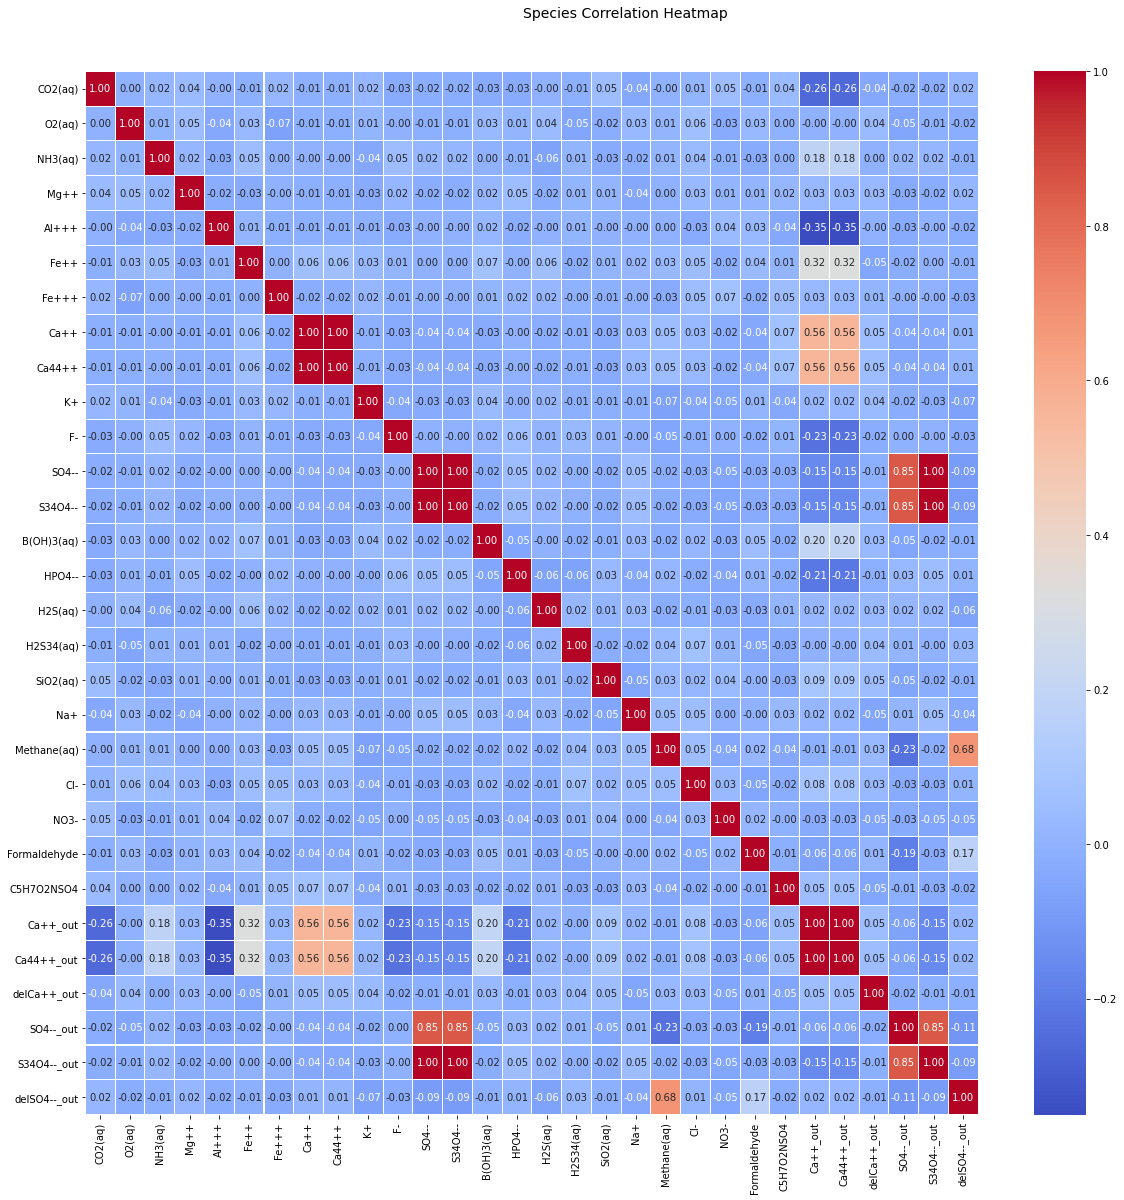

In [32]:
visualise = attribute_df
visualise['Ca++_out'] = labels_df['Ca++']
visualise['Ca44++_out'] = labels_df['Ca44++']
visualise['delCa++_out'] = labels_df['delCa++']
visualise['SO4--_out'] = labels_df['SO4--']
visualise['S34O4--_out'] = labels_df['S34O4--']
visualise['delSO4--_out'] = labels_df['delSO4--']
display(visualise.head())

f, ax = plt.subplots(figsize=(20, 18))
corr = visualise.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t = f.suptitle('Species Correlation Heatmap', fontsize=14)

In [ ]:
sns.pairplot(visualise)

In [6]:
# Generate training arrays.
labels_df = labels_df[['delSO4--', 'delCa++']]
test_labels_df = test_labels_df[['delSO4--', 'delCa++']]

x_train = attribute_df.to_numpy()
y_train = labels_df.to_numpy()

x_test = test_df.to_numpy()
y_test = test_labels_df.to_numpy()

In [7]:
metrics = mm.generate_metrics('delCa++', 'delSO4--', labels=labels_df)
print(metrics)

1
0
{'delCa++': <my_metrics.SpeciesRmse object at 0x147d0a130>, 'delSO4--': <my_metrics.SpeciesRmse object at 0x147d819a0>}


In [8]:
labels_df.describe()

,delSO4--,delCa++
count,1000.000000,1.000000e+03
mean,3.905435,2.120014e-02
std,20.253653,6.510931e-11
min,0.046189,2.120014e-02
25%,0.092538,2.120014e-02
50%,0.232985,2.120014e-02
75%,0.976529,2.120014e-02
max,373.609426,2.120014e-02


In [9]:
def train():
    # wandb configuration
    wandb.init(project="MSR-box-model")

    # Hyperparameters defaults.
    wandb.config.dropout = 0.2
    wandb.config.learning_rate = 0.1
    wandb.config.epochs = 100
    wandb.config.batch_size = 50

    # Define the model geometry.
    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
    tf.keras.layers.Dropout(wandb.config.dropout),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(2)
    ])

    # Compile the model.
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=wandb.config.learning_rate),
              loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
                 metrics=[mm.test_metric, metrics['delCa++'], metrics['delSO4--']])

    # Split the dataset into features and label.
    model.fit(x=x_train, y=y_train, batch_size=wandb.config.batch_size, epochs=wandb.config.epochs, validation_split = 0.1, shuffle=True, verbose=0, callbacks=[WandbCallback()])

In [10]:
train()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

